In [44]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt

import geopandas as gpd
import numpy as np
from shapely.geometry import LineString, MultiLineString
from shapely.ops import unary_union, split
from itertools import combinations
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:

sf_path = './shapefile/polygon_shapes.shp'
gdf = gpd.read_file(sf_path)
multiline = unary_union(gdf.geometry)

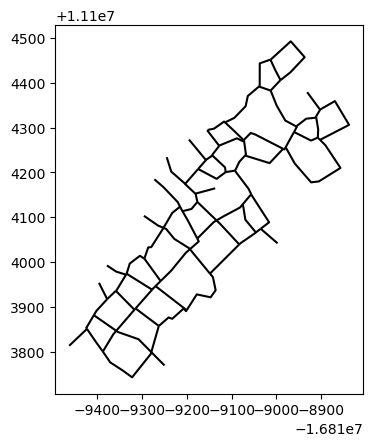

In [46]:
import geopandas as gpd

crs = gdf.crs

fig, ax = plt.subplots()
gdf.plot(ax=ax,color='black')
ax.set_aspect('equal')
plt.show()

In [47]:
def calculate_angle(junction, line):
    """ 
    """
    jc = np.array(junction.coords[0])[0:2]
    line = np.array(line.coords).T[0:2]
    reference = jc + [0, 1]

    distance = np.sqrt((jc[0] - line[0])**2 + (jc[1] - line[1])**2)
    nearest = np.argmin(distance)

    if nearest == 0:
        nearest += 1
    
    elif nearest == (len(distance) - 1):
        nearest -= 1

    point = line[:, nearest]
    vec1 = reference - jc
    vec2 = point - jc
    unit_vec1 = vec1 / np.linalg.norm(vec1)
    unit_vec2 = vec2 / np.linalg.norm(vec2)
    deg = np.rad2deg(np.arctan2(np.cross(unit_vec2, unit_vec1), np.dot(unit_vec2, unit_vec1)))

    return deg

In [48]:
# multiline = unary_union(gdf.geometry)
intersections = {}
lines = gdf.geometry.explode()
points = []
intersections = {}

for l1 in lines:
    for l2 in lines:
        if l1 != l2 and l1.intersects(l2):
            intersection_point = l1.intersection(l2)
            if intersection_point.type == 'Point':
                points.append(intersection_point)
                if intersection_point not in intersections:
                    intersections[intersection_point] = set()
                intersections[intersection_point].add(l1)
                intersections[intersection_point].add(l2)

points = []
jangles = []
jn = []

# Calculate angles for each intersection group
for point, lines in intersections.items():
    angles = []
    points.append(point)
    for line in lines:
        angle = calculate_angle(point, line)
        angles.append(angle)
    angles = sorted(angles)
    angles2 = np.roll(angles, 1)
    difference = np.exp(1j * np.deg2rad(angles)) * np.exp(1j * np.deg2rad(angles2)).conj()
    deg = np.rad2deg(np.angle(difference))
    for i in range(len(deg)):
        if deg[i] < 0:
            deg[i] += 360
    jangles.append(str(deg))
    jn.append(len(deg))


print(len(points))

data = {'geometry': points, 'angles': jangles, 'junctions': jn}
df = pd.DataFrame(data)
gdf_points = gpd.GeoDataFrame(df, geometry='geometry', crs=crs)

# Write the GeoDataFrame to a shapefile
gdf.to_file('./out/cracks.shp')
gdf_points.to_file('./out/junctions.shp')


46


/tmp/ipykernel_17632/3424562128.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  lines = gdf.geometry.explode()
/tmp/ipykernel_17632/3424562128.py:11: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if intersection_point.type == 'Point':


In [57]:
def orthog_index(angles):
    '''
        Given an arr ay of angles, compute an index where
        0 refers to mostly 60-30 degree angles
        1 refers to mostly 45-90-180 degree angles
    '''
    
    rad = np.deg2rad(angles)
    return np.cos(2 * rad)**2
    # return np.cos(2 * rad)**2

In [58]:
import ast

def str2lst(s):
    s = s.replace('[', '')
    s = s.replace(']', '')
    s = s.split(' ')
    s = [a for a in s if a != '']
    s = np.array(s).astype(np.float32)
    return s

angles = gdf_points['angles'].values
reconangles = []
for i in range(len(angles)):
    reconangles.append(str2lst(angles[i]))

reconangles = np.concatenate(reconangles)


Index(['geometry', 'angles', 'junctions'], dtype='object')


144


/tmp/ipykernel_17632/2235961096.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(nxticks.astype(int))
/tmp/ipykernel_17632/2235961096.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(nyticks.astype(int))


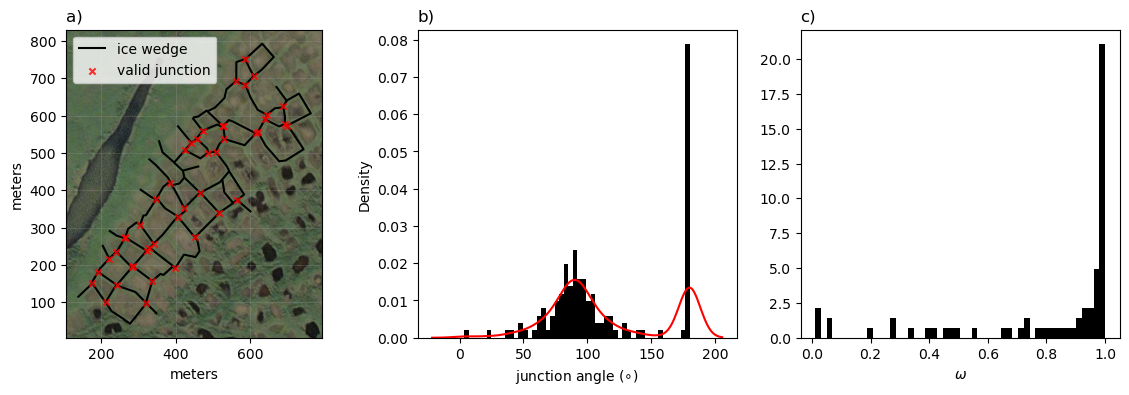

In [59]:
import seaborn as sns
import contextily as cx

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
omega = orthog_index(reconangles)


tileProvider = cx.providers.Esri.WorldImagery
attribution = tileProvider['attribution']
tileProvider['attribution'] = ''

gdf.plot(ax=ax[0], color='black', label='ice wedge')
gdf_points.plot(ax=ax[0], color='red', markersize=20, alpha=0.8, label='valid junction', zorder=10, marker="x")
cx.add_basemap(ax[0], crs=gdf_points.crs, source=tileProvider, alpha=1)

xticks = ax[0].get_xticks()
yticks = ax[0].get_yticks()

nxticks = xticks-xticks[0]
nyticks = yticks-yticks[0]

ax[0].set_xticklabels(nxticks.astype(int))
ax[0].set_yticklabels(nyticks.astype(int))
ax[0].set_ylabel('meters')
ax[0].set_xlabel('meters')
ax[0].legend(loc='best')



ax[0].set_aspect('equal')
ax[0].grid(alpha=0.2)

ax[0].set_title('a)', loc='left')
ax[1].set_title('b)', loc='left')
ax[2].set_title('c)', loc='left')


ax[1].hist(reconangles, density=True, bins=50, color='black')
sns.kdeplot(reconangles, ax=ax[1], bw_adjust=0.5, color='red')
ax[2].hist(omega, density=True, bins=50, color='black')
ax[1].set_xlabel(r'junction angle ($\circ$)')
ax[2].set_xlabel(r'$\omega$')
plt.show()
print(attribution)


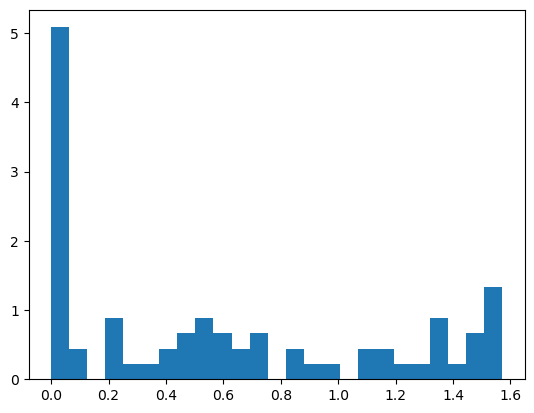

In [60]:
# plt.hist(reconangles, density=True, bins=25)
plt.hist(np.arccos(np.cos(4 * np.deg2rad(reconangles))**2), density=True, bins=25)

plt.show()